In [6]:
!pip install autogluon

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error

### 데이터 불러오기

In [9]:
spring = pd.read_csv("/content/drive/MyDrive/날씨 빅데이터 공모전/data/spring_train.csv")
spring_test = pd.read_csv("/content/drive/MyDrive/날씨 빅데이터 공모전/data/spring_test.csv")

### 지면온도 예측에 대한 RN(누적강수량)의 일부 값을 변경

In [10]:
spring = spring.replace({"1시간 누적 강수량(mm)" : [1.8, 3.3, 5.3, 19.5, 30.3, 623.5]}, -99.9)

spring_test = spring_test.replace({"1시간 누적 강수량(mm)" : [1.8, 3.3, 5.3, 19.5, 30.3, 623.5]}, -99.9)

#### 월, 일, 시간으로 분리

In [11]:
spring["hour"] = spring["mmddhh"] % 100
spring["day"] = (np.trunc((spring["mmddhh"] % 10000) / 100))
spring["month"] = np.trunc(spring["mmddhh"] / 10000)

spring_test["hour"] = spring_test["mmddhh"] % 100
spring_test["day"] = (np.trunc((spring_test["mmddhh"] % 10000) / 100))
spring_test["month"] = np.trunc(spring_test["mmddhh"] / 10000)

### 지면온도 예측에 대한 RN(누적강수량)의 일부 값을 변경

In [12]:
spring = spring.replace({"1시간 누적 강수량(mm)" : [1.8, 3.3, 5.3, 19.5, 30.3, 623.5]}, -99.9)

spring_test = spring_test.replace({"1시간 누적 강수량(mm)" : [1.8, 3.3, 5.3, 19.5, 30.3, 623.5]}, -99.9)

### 1시간 누적 일사량과 1시간 누적 일조량 칼럼 수정

In [13]:
spring_2 = [0,1,2,3,4,5,6,7,19,20,21,22,23]
spring_3 = [0,1,2,3,4,5,6,7,20,21,22,23]
spring_4 = [0,1,2,3,4,5,6,20,21,22,23]

for i in spring_2 :
    spring.loc[(spring["1시간 누적 일사량(MJ)"] == -99.9) & (spring["hour"] == i) & (spring["월"] == 2), "1시간 누적 일사량(MJ)"] = 0
    spring.loc[(spring["1시간 누적 일조량(초)"] == -99.9) & (spring["hour"] == i) & (spring["월"] == 2), "1시간 누적 일조량(초)"] = 0

for i in spring_3 :
    spring.loc[(spring["1시간 누적 일사량(MJ)"] == -99.9) & (spring["hour"] == i) & (spring["월"] == 3), "1시간 누적 일사량(MJ)"] = 0
    spring.loc[(spring["1시간 누적 일조량(초)"] == -99.9) & (spring["hour"] == i) & (spring["월"] == 3), "1시간 누적 일조량(초)"] = 0

for i in spring_4 :
    spring.loc[(spring["1시간 누적 일사량(MJ)"] == -99.9) & (spring["hour"] == i) & (spring["월"] == 4), "1시간 누적 일사량(MJ)"] = 0
    spring.loc[(spring["1시간 누적 일조량(초)"] == -99.9) & (spring["hour"] == i) & (spring["월"] == 4), "1시간 누적 일조량(초)"] = 0

for i in spring_2 :
    spring_test.loc[(spring_test["1시간 누적 일사량(MJ)"] == -99.9) & (spring_test["hour"] == i) & (spring_test["월"] == 2), "1시간 누적 일사량(MJ)"] = 0
    spring_test.loc[(spring_test["1시간 누적 일조량(초)"] == -99.9) & (spring_test["hour"] == i) & (spring_test["월"] == 2), "1시간 누적 일조량(초)"] = 0

for i in spring_3 :
    spring_test.loc[(spring_test["1시간 누적 일사량(MJ)"] == -99.9) & (spring_test["hour"] == i) & (spring_test["월"] == 3), "1시간 누적 일사량(MJ)"] = 0
    spring_test.loc[(spring_test["1시간 누적 일조량(초)"] == -99.9) & (spring_test["hour"] == i) & (spring_test["월"] == 3), "1시간 누적 일조량(초)"] = 0

for i in spring_4 :
    spring_test.loc[(spring_test["1시간 누적 일사량(MJ)"] == -99.9) & (spring_test["hour"] == i) & (spring_test["월"] == 4), "1시간 누적 일사량(MJ)"] = 0
    spring_test.loc[(spring_test["1시간 누적 일조량(초)"] == -99.9) & (spring_test["hour"] == i) & (spring_test["월"] == 4), "1시간 누적 일조량(초)"] = 0


spring.loc[(spring["1시간 누적 일사량(MJ)"] == -99.9) & (spring["1시간 누적 일조량(초)"] == 0), "1시간 누적 일사량(MJ)"] = 0
spring.loc[(spring["1시간 누적 일사량(MJ)"] == 0) & (spring["1시간 누적 일조량(초)"] == -99.9), "1시간 누적 일조량(초)"] = 0

spring_test.loc[(spring_test["1시간 누적 일사량(MJ)"] == -99.9) & (spring_test["1시간 누적 일조량(초)"] == 0), "1시간 누적 일사량(MJ)"] = 0
spring_test.loc[(spring_test["1시간 누적 일사량(MJ)"] == 0) & (spring_test["1시간 누적 일조량(초)"] == -99.9), "1시간 누적 일조량(초)"] = 0

### 결측치 처리

In [14]:
spring = spring.replace([-99, -99.9, -999], np.nan)

spring_test = spring_test.replace([-99, -99.9, -999], np.nan)

### 사용하지 않는 칼럼 제거

In [15]:
spring = spring.drop(["mmddhh", "적설 깊이(cm)", "월"], axis = 1)

spring_test = spring_test.drop(["mmddhh", "적설 깊이(cm)", "월"], axis = 1)

### 1시간 누적 강수유무와 1시간 누적 강수량 칼럼 수정

In [16]:
spring.loc[(spring["1시간 누적 강수유무(분)"]== 0) & (spring["1시간 누적 강수량(mm)"].isnull()), "1시간 누적 강수량(mm)"] = 0
spring.loc[spring["1시간 누적 강수량(mm)"].isnull(), "1시간 누적 강수량(mm)"] = 0
spring = spring.drop("1시간 누적 강수유무(분)", axis = 1)

spring_test.loc[(spring_test["1시간 누적 강수유무(분)"]== 0) & (spring["1시간 누적 강수량(mm)"].isnull()), "1시간 누적 강수량(mm)"] = 0
spring_test.loc[spring_test["1시간 누적 강수량(mm)"].isnull(), "1시간 누적 강수량(mm)"] = 0
spring_test = spring_test.drop("1시간 누적 강수유무(분)", axis = 1)

### 인덱스 초기화

In [17]:
spring = spring.reset_index(drop=True)
spring

,지점,연도,1시간 평균 기온(C),1시간 평균 이슬점온도(C),1시간 평균 상대습도(%),1시간 평균풍속(m/s),1시간 누적 강수량(mm),현천,1시간 평균 지면온도(C),1시간 누적 일사량(MJ),1시간 누적 일조량(초),hour,day,month
0,1,A,-9.9,-10.7,93.9,0.6,0.0,H,-1.3,0.00,0.0,0,1.0,2.0
1,1,A,-10.8,-11.6,93.8,0.6,0.0,H,-1.5,0.00,0.0,1,1.0,2.0
2,1,A,-11.4,-12.1,94.6,0.7,0.0,H,-1.7,0.00,0.0,2,1.0,2.0
3,1,A,-11.6,-12.5,93.4,0.6,0.0,H,-1.8,0.00,0.0,3,1.0,2.0
4,1,A,-11.8,-12.7,93.0,0.6,0.0,H,-2.0,0.00,0.0,4,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107035,10,E,18.5,-4.4,20.7,4.9,0.0,C,18.0,0.09,0.3,19,30.0,4.0
107036,10,E,17.6,-4.9,21.2,5.0,0.0,C,16.2,0.00,0.0,20,30.0,4.0
107037,10,E,17.1,-2.3,26.6,3.4,0.0,R,16.2,0.00,0.0,21,30.0,4.0
107038,10,E,15.8,2.3,40.4,4.1,0.4,R,13.7,0.00,0.0,22,30.0,4.0


### 라벨 인코딩 수행

In [18]:
cha = ["지점", "연도", "현천"]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for i in cha:
    spring[i] = le.fit_transform(spring[i])

    for label in np.unique(spring_test[i]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)

    spring_test[i] = le.transform(spring_test[i])




<ipython-input-18-157a1dcb24af>:11: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if label not in le.classes_:



## 파생변수 추가

### 1. 기온 변화량

In [19]:
# 파생변수 추가
spring = spring.reset_index(drop = True)
spring_test = spring_test.reset_index(drop=True)

spring["기온변화량"] = -(spring["1시간 평균 기온(C)"] - spring["1시간 평균 기온(C)"][1:].reset_index(drop = True))
spring["기온변화량"] = spring["기온변화량"].shift(1)

spring_test["기온변화량"] = -(spring_test["1시간 평균 기온(C)"] - spring_test["1시간 평균 기온(C)"][1:].reset_index(drop = True))
spring_test["기온변화량"] = spring_test["기온변화량"].shift(1)


### 2. 상대습도 변화량

In [20]:
spring["상대습도변화량"] = -(spring["1시간 평균 상대습도(%)"] - spring["1시간 평균 상대습도(%)"][1:].reset_index(drop = True))
spring["상대습도변화량"] = spring["상대습도변화량"].shift(1)

spring_test["상대습도변화량"] = -(spring_test["1시간 평균 상대습도(%)"] - spring_test["1시간 평균 상대습도(%)"][1:].reset_index(drop = True))
spring_test["상대습도변화량"] = spring_test["상대습도변화량"].shift(1)


### 3. 평균 기온 * 평균 상대습도

In [21]:
spring["평균기온*평균상대습도"] = spring["1시간 평균 기온(C)"] * spring["1시간 평균 상대습도(%)"]

spring_test["평균기온*평균상대습도"] = spring_test["1시간 평균 기온(C)"] * spring_test["1시간 평균 상대습도(%)"]


### 4. 1시간 누적 일사량 * 1시간 누적 일조량

In [22]:
spring["1시간 누적 일사량 * 1시간 누적 일조량"] = spring["1시간 누적 일사량(MJ)"] * spring["1시간 누적 일조량(초)"]

spring_test["1시간 누적 일사량 * 1시간 누적 일조량"] = spring_test["1시간 누적 일사량(MJ)"] * spring_test["1시간 누적 일조량(초)"]

### 2개 이상 연속되는 결측치 찾기 및 제거

In [23]:
lists = ["1시간 평균 기온(C)", "1시간 평균 이슬점온도(C)", "1시간 평균 상대습도(%)", "1시간 평균풍속(m/s)" , "1시간 평균 지면온도(C)", "1시간 누적 일사량(MJ)", "1시간 누적 일조량(초)"
,"기온변화량" ,"상대습도변화량", "평균기온*평균상대습도", "1시간 누적 일사량 * 1시간 누적 일조량"]
for i in lists:
  ans = spring[spring[i].isnull()].index
  cons = []
  for j in range(len(ans)-1) :
    if ans[j+1] - ans[j] == 1 : # i+1번째 숫자와 i번째 숫자의 차이가 1이라면(연속이라면)
        cons.extend([ans[j],ans[j+1]]) #i+1번째 숫자와 i번째 숫자를 결과 출력할 리스트에 추가
  delete = list(set(cons)) #위 알고리즘으로 하면 만일 숫자가 23,24,25라면 23, 24, 24, 25로 저장되기 때문에 중복되는 숫자를 제거

  spring = spring.drop(spring.index[delete])
  #인덱스를 초기화
  spring = spring.reset_index(drop=True)


In [24]:
spring

,지점,연도,1시간 평균 기온(C),1시간 평균 이슬점온도(C),1시간 평균 상대습도(%),1시간 평균풍속(m/s),1시간 누적 강수량(mm),현천,1시간 평균 지면온도(C),1시간 누적 일사량(MJ),1시간 누적 일조량(초),hour,day,month,기온변화량,상대습도변화량,평균기온*평균상대습도,1시간 누적 일사량 * 1시간 누적 일조량
0,0,0,-9.9,-10.7,93.9,0.6,0.0,3,-1.3,0.00,0.0,0,1.0,2.0,NaN,NaN,-929.61,0.000
1,0,0,-10.8,-11.6,93.8,0.6,0.0,3,-1.5,0.00,0.0,1,1.0,2.0,-0.9,-0.1,-1013.04,0.000
2,0,0,-11.4,-12.1,94.6,0.7,0.0,3,-1.7,0.00,0.0,2,1.0,2.0,-0.6,0.8,-1078.44,0.000
3,0,0,-11.6,-12.5,93.4,0.6,0.0,3,-1.8,0.00,0.0,3,1.0,2.0,-0.2,-1.2,-1083.44,0.000
4,0,0,-11.8,-12.7,93.0,0.6,0.0,3,-2.0,0.00,0.0,4,1.0,2.0,-0.2,-0.4,-1097.40,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106615,9,4,18.5,-4.4,20.7,4.9,0.0,0,18.0,0.09,0.3,19,30.0,4.0,-1.1,0.1,382.95,0.027
106616,9,4,17.6,-4.9,21.2,5.0,0.0,0,16.2,0.00,0.0,20,30.0,4.0,-0.9,0.5,373.12,0.000
106617,9,4,17.1,-2.3,26.6,3.4,0.0,4,16.2,0.00,0.0,21,30.0,4.0,-0.5,5.4,454.86,0.000
106618,9,4,15.8,2.3,40.4,4.1,0.4,4,13.7,0.00,0.0,22,30.0,4.0,-1.3,13.8,638.32,0.000


In [33]:
spring.isnull().sum()

지점                         0
연도                         0
1시간 평균 기온(C)               0
1시간 평균 이슬점온도(C)            0
1시간 평균 상대습도(%)             0
1시간 평균풍속(m/s)              5
1시간 누적 강수량(mm)             0
현천                         0
1시간 평균 지면온도(C)             7
1시간 누적 일사량(MJ)             1
1시간 누적 일조량(초)              1
hour                       0
day                        0
month                      0
기온변화량                      1
상대습도변화량                    1
평균기온*평균상대습도                0
1시간 누적 일사량 * 1시간 누적 일조량    1
dtype: int64

### 결측치 채우기 : 선형 보간

In [25]:
spring = spring.interpolate(method = 'linear')

spring_test = spring_test.interpolate(method = 'linear')

### autogluon 적용

In [26]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [27]:
# 2~4년도의 데이터를 train, 1년도의 데이터를 validation, 0년도의 데이터를 test로 하여 autogluon 적용

auto_spring_train = spring.loc[(spring["연도"] != 3) & (spring["연도"] != 4)]
auto_spring_val = spring.loc[spring["연도"] == 3]

auto_spring_test = spring.loc[spring["연도"] == 4]

In [28]:
predictor = TabularPredictor(label="1시간 평균 지면온도(C)", eval_metric = "mae").fit(train_data = auto_spring_train)

No path specified. Models will be saved in: "AutogluonModels/ag-20230705_064947/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230705_064947/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Apr 29 09:15:28 UTC 2023
Disk Space Avail:   83.42 GB / 115.66 GB (72.1%)
Train Data Rows:    63758
Train Data Columns: 17
Label Column: 1시간 평균 지면온도(C)
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (50.6, -18.3, 8.7383, 9.36147)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerat

[1000]	valid_set's l1: 1.05788
[2000]	valid_set's l1: 0.978487
[3000]	valid_set's l1: 0.93357
[4000]	valid_set's l1: 0.904092
[5000]	valid_set's l1: 0.882945
[6000]	valid_set's l1: 0.86668
[7000]	valid_set's l1: 0.852694
[8000]	valid_set's l1: 0.841933
[9000]	valid_set's l1: 0.831625
[10000]	valid_set's l1: 0.823633


	-0.8236	 = Validation score   (-mean_absolute_error)
	87.21s	 = Training   runtime
	5.5s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l1: 0.848757
[2000]	valid_set's l1: 0.763304
[3000]	valid_set's l1: 0.725088
[4000]	valid_set's l1: 0.700477
[5000]	valid_set's l1: 0.682937
[6000]	valid_set's l1: 0.670766
[7000]	valid_set's l1: 0.662003
[8000]	valid_set's l1: 0.653795
[9000]	valid_set's l1: 0.648251
[10000]	valid_set's l1: 0.644538


	-0.6445	 = Validation score   (-mean_absolute_error)
	71.23s	 = Training   runtime
	4.25s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-1.0575	 = Validation score   (-mean_absolute_error)
	186.55s	 = Training   runtime
	0.35s	 = Validation runtime
Fitting model: CatBoost ...
	-0.727	 = Validation score   (-mean_absolute_error)
	413.53s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-1.0081	 = Validation score   (-mean_absolute_error)
	69.36s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.9743	 = Validation score   (-mean_absolute_error)
	97.91s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: XGBoost ...
	-0.7137	 = Validation score   (-mean_absolute_error)
	143.19s	 = Training   runtime
	13.45s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-1.1666	 = Validation score   (-mean_absolute_error)
	247.43s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model

[1000]	valid_set's l1: 0.716144
[2000]	valid_set's l1: 0.651754
[3000]	valid_set's l1: 0.62779
[4000]	valid_set's l1: 0.61511
[5000]	valid_set's l1: 0.606857
[6000]	valid_set's l1: 0.602068
[7000]	valid_set's l1: 0.598833
[8000]	valid_set's l1: 0.596548
[9000]	valid_set's l1: 0.595338
[10000]	valid_set's l1: 0.594523


	-0.5945	 = Validation score   (-mean_absolute_error)
	119.24s	 = Training   runtime
	8.66s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.5919	 = Validation score   (-mean_absolute_error)
	0.44s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 1499.27s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230705_064947/")


In [29]:
predictor.leaderboard(auto_spring_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesMSE,-1.467728,-1.008055,1.526702,0.323400,69.363608,1.526702,0.323400,69.363608,1,True,7
1,RandomForestMSE,-1.538500,-1.057516,2.472227,0.354674,186.549932,2.472227,0.354674,186.549932,1,True,5
2,WeightedEnsemble_L2,-1.540353,-0.591851,242.498750,26.362339,334.111244,0.038057,0.002072,0.442615,2,True,12
3,LightGBMLarge,-1.544145,-0.594520,82.077189,8.661196,119.244926,82.077189,8.661196,119.244926,1,True,11
4,CatBoost,-1.559312,-0.727045,0.230438,0.028753,413.530764,0.230438,0.028753,413.530764,1,True,6
5,LightGBM,-1.570055,-0.644537,56.668350,4.252395,71.230083,56.668350,4.252395,71.230083,1,True,4
6,XGBoost,-1.593003,-0.713712,103.715154,13.446676,143.193619,103.715154,13.446676,143.193619,1,True,9
7,LightGBMXT,-1.633430,-0.823622,62.390153,5.500896,87.212250,62.390153,5.500896,87.212250,1,True,3
8,NeuralNetTorch,-1.937128,-1.166632,0.126000,0.027921,247.428092,0.126000,0.027921,247.428092,1,True,10
9,KNeighborsDist,-2.451436,-2.096709,10.771579,1.374507,0.062630,10.771579,1.374507,0.062630,1,True,2


In [3]:
! pip install pygraphviz

  Using cached pygraphviz-1.11.zip (120 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.11-cp310-cp310-linux_x86_64.whl size=184246 sha256=3362fb5d9b15775f380bbe299064a1502c5537d2efc04a6d6c0eb312d5d733ca
  Stored in directory: /root/.cache/pip/wheels/5b/ee/36/f47a0d35664fbe1a2b5a433ae33c6ad636b00bb231f68a9aaa
Successfully built pygraphviz


In [2]:
! sudo apt-get install graphviz graphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-3build2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 15 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd6

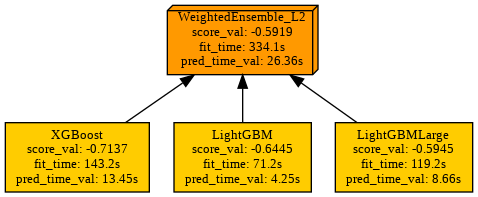

In [30]:
from IPython.display import Image, display
display(Image(filename=predictor.plot_ensemble_model()))

### spring_test에 적용

In [39]:
spring_pred = predictor.predict(spring_test)
#spring_pred = predictor_1.predict(spring_test)

In [41]:
spring_pred

0       -0.279676
1       -1.953628
2       -1.933735
3       -2.598596
4       -2.421904
          ...    
6403    15.428689
6404    13.272262
6405    12.543273
6406    12.494930
6407    12.536744
Name: 1시간 평균 지면온도(C), Length: 6408, dtype: float32

In [42]:
file_name = '/content/drive/MyDrive/날씨 빅데이터 공모전/data/subminssionUser.xlsx'

writer = pd.ExcelWriter(file_name, mode='a', engine='openpyxl', if_sheet_exists='overlay')
submission_spring = pd.read_excel(file_name, sheet_name= "SPRING")

#제출 파일에 빠진 날짜 찾아서 테스트에서도 빼버리기
spring_indexdrop = spring_test[(spring_test["month"] == 3) & (spring_test["day"] == 23) & (spring_test["hour"] == 14)].index
spring_pred = spring_pred.drop(spring_indexdrop)
submission_spring["TS"] = spring_pred

submission_spring.to_excel(
    writer,
    sheet_name='SPRING',
    index=False,
    # header = None
    )
writer.save()
writer.close()

<ipython-input-42-502a7f2f4265>:17: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
